In [1]:
import utility_common as common
import utility_commonPlot as commonp
from fit_torch_model import *

# 1. Load Input-Label and Model

In [2]:
# basedir = common.getBaseDirectory()
# common.symlink(basedir+"data/templatesShape",basedir+"data/templates")

In [3]:
# Templetes(counts) and Targets
name = common.getBaseDirectory() + "data/templates/templates{}_.npy"
X = tc.from_numpy( np.load(name.format('X')) ).type(tc.FloatTensor ).to(device)
Y = tc.from_numpy( np.load(name.format('Y')) ).type(tc.FloatTensor ).to(device)
#Y = tc.sum(X,1).to(device)

In [4]:
# Model and optimizer
model     = PredictiveModel(controlTauID=True).to(device)
optimizer = tc.optim.LBFGS(model.parameters(),
                              lr=0.001, max_iter=1e4, 
                              tolerance_grad=1e-05, 
                              tolerance_change=1e-9) 

# 2. Training 

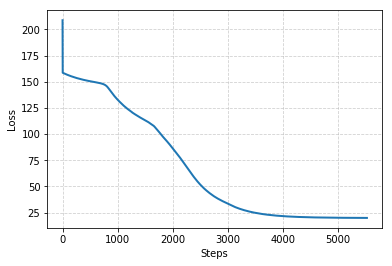

In [5]:
losses = []
# define backprop step
def closure():
    optimizer.zero_grad()
    y,regu = model.forward(X)
    loss = tc.sum( (y-Y)**2/(2*Y+0.1) ) + regu
    losses.append(loss)
    loss.backward(retain_graph=True) 
    return loss
# run optimization
optimizer.step(closure)
showLossHistory(losses)

# 3. Calculate Hessian of Loss

In [6]:
# forward prop X
y,regu = model.forward(X)

# calculate loss and params
loss = tc.sum( (y-Y)**2/(2*Y) ) + regu

# autograd loss w.r.t. params
hess = autograd2nd(loss, model)
hessinv = np.linalg.inv(hess)
sig = np.sqrt(hessinv.diagonal())
cor = hessinv/np.outer(sig, sig)

# show correlation and sigma
commonp.showParameterCovMat(cor,sig)

ValueError: only one element tensors can be converted to Python scalars

In [7]:
print(sig[0:3]/0.1080*100)
print(sig[3:])

NameError: name 'sig' is not defined

In [8]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name,param.data)

layer_beta.params tensor([0.1106, 0.1098, 0.0932])
layer_btl.params tensor([-0.0020,  0.0156])
layer_xs.params tensor([-0.3618, -0.0511,  0.8653, -0.9179,  0.0440,  0.7401, -0.9181, -0.2529,
        -0.0839])
layer_eff.params tensor([-0.5811,  0.3195,  1.3668])
layer_shape.params tensor([ 0.0431, -0.0162,  0.5088, -0.1523, -0.0279, -0.0109, -0.1949])


In [3]:
# print Model Paramters
# params = dict(model.named_parameters())
# bwe = params['layer_beta.bwe'].data
# bwm = params['layer_beta.bwm'].data
# bwt = params['layer_beta.bwt'].data
# print(bwe,bwm,bwt)

In [ ]:
#temp = np.transpose(X,(0,1,2))
temp = np.concatenate(X.numpy(),axis=1)
temp = np.sum(temp,axis=0)

targ = np.concatenate(Y.numpy(),axis=0)

plt.figure(figsize=(20,4),facecolor='w')
c = np.arange(temp.size)
plt.plot(c, temp, lw=2)
plt.scatter(c, targ, c='k',s=10)
plt.yscale('log')
plt.xlim(c.min(),c.max())